# ENEL 610- Biometric Technologies and Systems
## Ocular Disease Intelligent Recognition
### Normal v/s Cataract v/s Glaucoma v/s Myopia Prediction 

## Getting the dataset

In [1]:
# Downloading the dataset

import os
os.environ["KAGGLE_CONFIG_DIR"] = '/content'     # Setting the Environment variable
!chmod 600 /content/kaggle.json                     
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k        # API command to directly import the dataset to colab.
!unzip *.zip && rm *.zip                         # Unzipping the dataset and simultaneously deleting the zip.  

Streaming output truncated to the last 5000 lines.
  inflating: preprocessed_images/2179_left.jpg  
  inflating: preprocessed_images/2179_right.jpg  
  inflating: preprocessed_images/217_left.jpg  
  inflating: preprocessed_images/217_right.jpg  
  inflating: preprocessed_images/2180_left.jpg  
  inflating: preprocessed_images/2180_right.jpg  
  inflating: preprocessed_images/2181_left.jpg  
  inflating: preprocessed_images/2181_right.jpg  
  inflating: preprocessed_images/2182_left.jpg  
  inflating: preprocessed_images/2182_right.jpg  
  inflating: preprocessed_images/2183_left.jpg  
  inflating: preprocessed_images/2183_right.jpg  
  inflating: preprocessed_images/2184_left.jpg  
  inflating: preprocessed_images/2184_right.jpg  
  inflating: preprocessed_images/2185_left.jpg  
  inflating: preprocessed_images/2185_right.jpg  
  inflating: preprocessed_images/2187_left.jpg  
  inflating: preprocessed_images/2187_right.jpg  
  inflating: preprocessed_images/2189_left.jpg  
  inflating

## Importing necessary libraries, functions 

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
import cv2, random
import matplotlib.pyplot as plt
import itertools

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Flatten, Dense, Input, Conv2D, MaxPool2D, AveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Adam 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.metrics import f1_score, confusion_matrix
from tensorflow.keras.preprocessing.image import img_to_array
from tqdm import tqdm

In [4]:
# Importing pre-trained models for transfer learning

from tensorflow.keras.applications import VGG19, InceptionV3, Xception

In [5]:
AUC_value = AUC(curve = 'ROC', name = 'auc_value', multi_label = False) 
# This metric creates four local variables, true_positives, true_negatives, false_positives and false_negatives that are used to compute the AUC. 
# Here, receiver operating characteristics at default threshold is being used.
# It tells us how much area at the given threshold is the ROC curve covering. Higher the area, better the classifier.

In [6]:
# Global Variables

join = True                                                                     # If true, concatenate the data
image_size = 224                                                                # Desired Image Size
i_shape = (image_size, image_size, 3)                                           # Input image shape     

lr_cnn = 1e-5                                                                   # Learning rate for training
lr_ft = 1e-6                                                                    # Learning rate for fine-tuning

class_names = ['Normal', 'Cataract', 'Glaucoma', 'Myopia']                      # For this notebook
classes = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'Age related Macular Degeneration', 'Hypertension', 'Pathological Myopia', 'Other abnormalities']

testing = False                                                                 # Lets you test our saved models if True, otherwise whole training will be done.

## Exploratory Data Analysis

In [7]:
data = pd.read_csv('/content/full_df.csv')          # Path to full_df.csv
print(data.head(5))      # Displaying the top three rows and all the columns of the dataset

   ID  Patient Age Patient Sex  ... labels                    target     filename
0   0           69      Female  ...  ['N']  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg
1   1           57        Male  ...  ['N']  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg
2   2           42        Male  ...  ['D']  [0, 1, 0, 0, 0, 0, 0, 0]  2_right.jpg
3   4           53        Male  ...  ['D']  [0, 1, 0, 0, 0, 0, 0, 0]  4_right.jpg
4   5           50      Female  ...  ['D']  [0, 1, 0, 0, 0, 0, 0, 0]  5_right.jpg

[5 rows x 19 columns]


In [8]:
print(data.columns)

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename'],
      dtype='object')


In [9]:
print(data.info())

# It can be seen that there no null values in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [10]:
DATA_PATH = '/content/ODIR-5K/ODIR-5K/data.xlsx'            # Path to data.xlsx
main_df = pd.read_excel(DATA_PATH)
sample_in_classes = main_df.iloc[:, -8:]
all_classes = sample_in_classes.sum() 
print(all_classes)

# The data set is highly imbalanced. 
# Only 103 images are there for Hypertension (H) while 1000+ images are there Diabetic(D) or Normal(N) class

N    1140
D    1128
G     215
C     212
A     164
H     103
M     174
O     979
dtype: int64


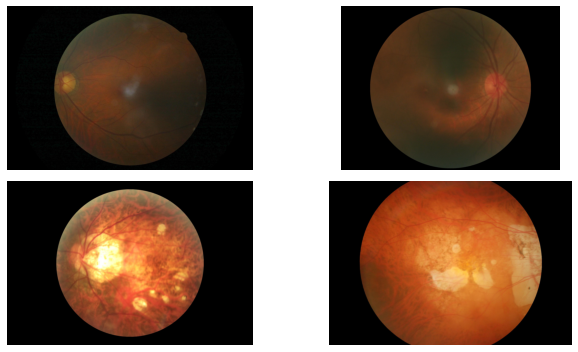

In [11]:
# Displaying some random images from the dataset
show_images = ['/content/ODIR-5K/ODIR-5K/Training Images/1006_left.jpg', '/content/ODIR-5K/ODIR-5K/Training Images/0_right.jpg', '/content/ODIR-5K/ODIR-5K/Training Images/1537_left.jpg', '/content/ODIR-5K/ODIR-5K/Training Images/1613_right.jpg']
count = 0

plt.figure(figsize = (10, 5))
for iter in show_images:
    im = cv2.imread(iter)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 2, 1 + count)
    plt.imshow(im)
    plt.axis('off')
    count += 1
plt.tight_layout()

# It can be observed that the images are of different sizes.

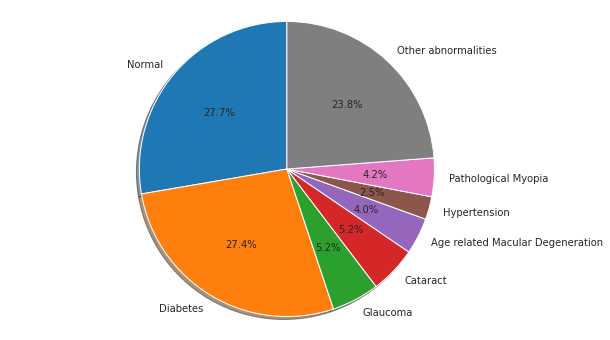

In [12]:
# Visualizing the dataset
plt.figure(figsize = (10, 6))
plt.pie(all_classes, labels = classes, startangle = 90, autopct='%1.1f%%', shadow = True)
plt.axis('equal')
plt.show()

In [13]:
# Function to plot the countplot

def cplot(variable, data_f, hue = None):
    sns.countplot(x = data_f[variable], hue = hue, palette = 'Paired')
    plt.title("{} distribution".format(variable))
    plt.tight_layout()
    plt.show()

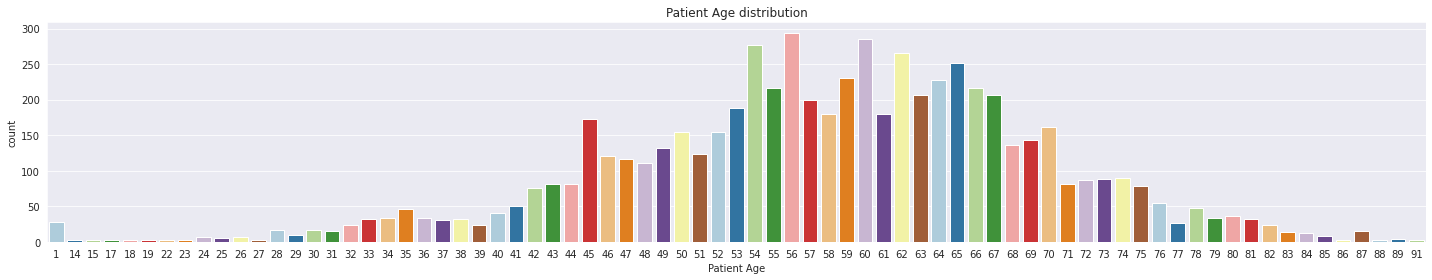

In [14]:
plt.figure(figsize = (20, 4))
cplot('Patient Age', data)      # It can be observed that most of the patients are fairly old

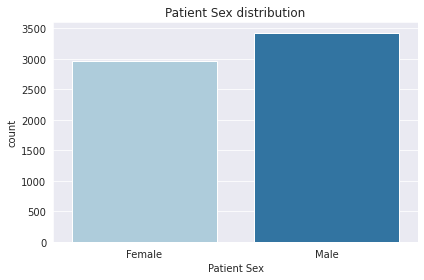

In [15]:
cplot('Patient Sex', data)     # More number of male patients than female patients

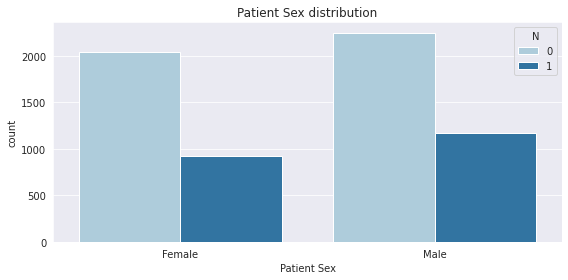

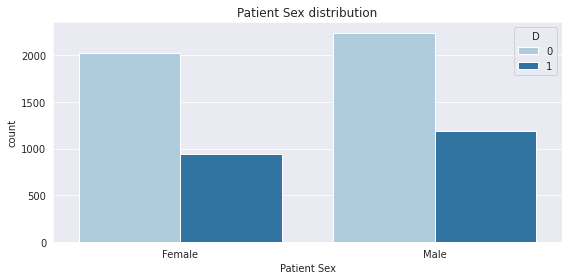

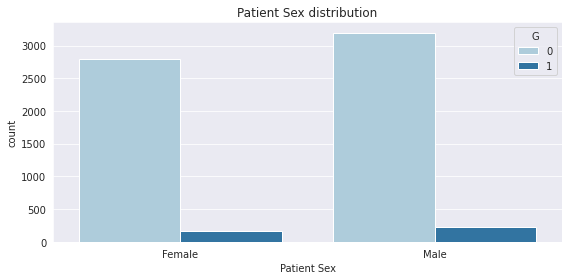

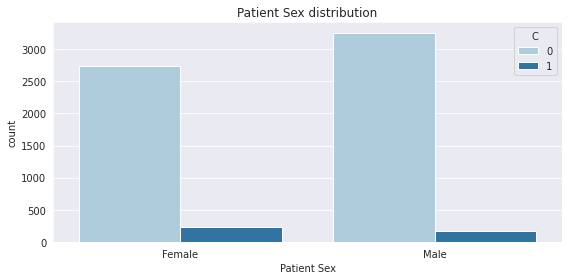

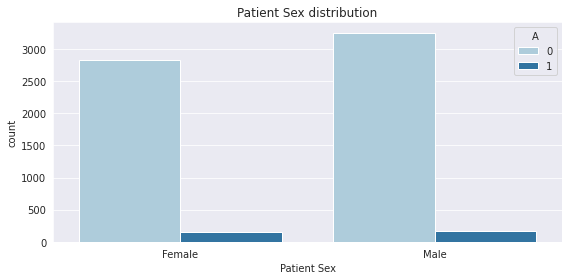

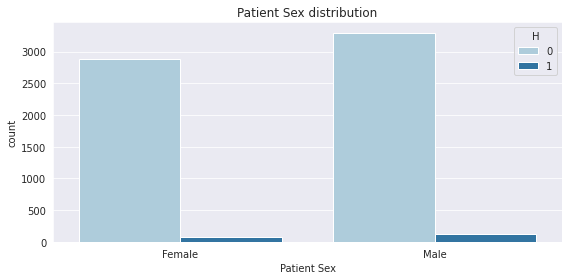

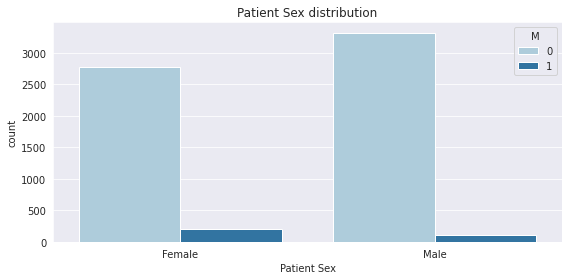

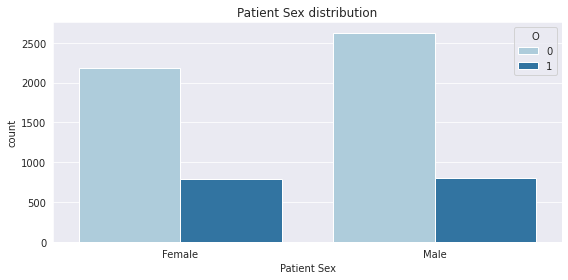

In [16]:
abbrevated = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
for plot in range(8):
    plt.figure(figsize = (8, 4))
    cplot('Patient Sex', data, hue = data[abbrevated[plot]])
    plt.show() 

# 0- Disease not present, 1- Disease present

In [17]:
# Plotting the correlation matrix to check if a patient is suffering from two or more than two diseases at a time.
# For example: if we consider first row, it can be observed that 15% patient suffering from glaucoma are also Diabetic.

columns = main_df.iloc[:,-8:]
normalize = columns.sum()                     # Finding the sum of each column
correlation = columns.T.dot(columns)          # Correlation = C.(C)^T; (C)^T is the transpose is the transpose of C, and '.' indicates a dot product
correlation_2 = correlation / normalize       # Normalizing the values to be in between 0 and 1; 0- No correlation, 1- 100% correlated
correlation_2.style.background_gradient().set_precision(3)          # Rounding up to 3 decimal points.

,N,D,G,C,A,H,M,O
N,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
D,0.000,1.000,0.149,0.184,0.098,0.437,0.109,0.309
G,0.000,0.028,1.000,0.014,0.067,0.078,0.040,0.050
C,0.000,0.035,0.014,1.000,0.000,0.019,0.000,0.032
A,0.000,0.014,0.051,0.000,1.000,0.039,0.017,0.016
H,0.000,0.040,0.037,0.009,0.024,1.000,0.000,0.012
M,0.000,0.017,0.033,0.000,0.018,0.000,1.000,0.045
O,0.000,0.269,0.228,0.146,0.098,0.117,0.253,1.000


## Dataset Creation
### Making a separate dataset having images from cataract and normal class.

In [18]:
# Defining a function to find a keyword (default - cataract, can be overwrite by specifying the keyword) in the text

def if_keyword(text, keyword):
    if keyword in text:
        return 1
    else:
        return 0

In [19]:
# Finding the keyword in left and right diagnostic keywords.

data["left_cataract"] = data["Left-Diagnostic Keywords"].apply(lambda x: if_keyword(x, 'cataract'))
data["right_cataract"] = data["Right-Diagnostic Keywords"].apply(lambda x: if_keyword(x, 'cataract'))

data['left_normal'] = data['Left-Diagnostic Keywords'].apply(lambda x: if_keyword(x, 'normal fundus'))
data['right_normal'] = data['Right-Diagnostic Keywords'].apply(lambda x: if_keyword(x, 'normal fundus'))

data['left_glaucoma'] = data['Left-Diagnostic Keywords'].apply(lambda x: if_keyword(x, 'glaucoma'))
data['right_glaucoma'] = data['Right-Diagnostic Keywords'].apply(lambda x: if_keyword(x, 'glaucoma'))

data['left_myopia'] = data['Left-Diagnostic Keywords'].apply(lambda x: if_keyword(x, 'pathological myopia'))
data['right_myopia'] = data['Right-Diagnostic Keywords'].apply(lambda x: if_keyword(x, 'pathological myopia'))

In [20]:
# Images having 'cataract' associated with their Diagnostic Keywords

left_cataract = data.loc[(data.C == 1) & (data.left_cataract == 1)]["Left-Fundus"].values
right_cataract = data.loc[(data.C == 1) & (data.right_cataract == 1)]["Right-Fundus"].values

# 300-Images having 'normal' associated with their Diagnostic Keywords
# All or more images can be taken into consideration by removing or changing the sample function 

left_normal = data.loc[(data.N == 1) & (data.left_normal == 1)]["Left-Fundus"].sample(300, random_state = 11).values
right_normal = data.loc[(data.N == 1) & (data.right_normal == 1)]["Right-Fundus"].sample(300, random_state = 11).values

left_glaucoma = data.loc[(data.G == 1) & (data.left_glaucoma == 1)]["Left-Fundus"].values
right_glaucoma = data.loc[(data.G == 1) & (data.right_glaucoma == 1)]["Right-Fundus"].values

left_myopia = data.loc[(data.M == 1) & (data.left_myopia == 1)]["Left-Fundus"].values
right_myopia = data.loc[(data.M == 1) & (data.right_myopia == 1)]["Right-Fundus"].values

In [21]:
# Joining both the arrays (left eye's and right eye's diagnosys) into one single arrays for each of the classes.

if join:
    cataract = np.concatenate((left_cataract, right_cataract), axis = 0)
    normal = np.concatenate((left_normal, right_normal), axis = 0)
    glaucoma = np.concatenate((left_glaucoma, right_glaucoma), axis = 0)
    myopia = np.concatenate((left_myopia, right_myopia), axis = 0)
    join = False

print(f'Cataract: {len(cataract)} \t Normal: {len(normal)} \t Glaucoma: {len(glaucoma)} \t Myopia: {len(myopia)}')

Cataract: 594 	 Normal: 600 	 Glaucoma: 616 	 Myopia: 457


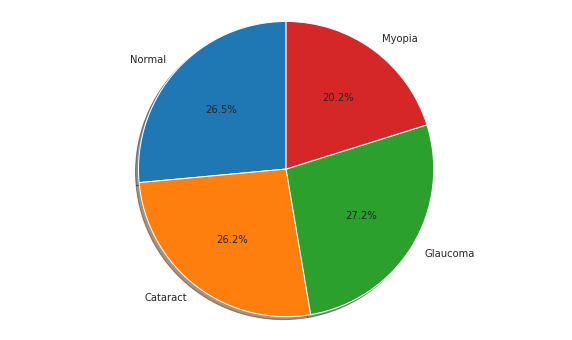

In [22]:
# Visualizing the dataset
our_classes = [600, 594, 616, 457]
plt.figure(figsize = (10, 6))
plt.pie(our_classes, labels = class_names, startangle = 90, autopct='%1.1f%%', shadow = True)
plt.axis('equal')
plt.show()

In [23]:
def CLAHE(img, clipLimit, tileGridSize):
  clahe = cv2.createCLAHE(clipLimit = clipLimit, tileGridSize = tileGridSize)
  lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)  # convert from BGR to LAB color space
  l, a, b = cv2.split(lab)  # split on 3 different channels
  l2 = clahe.apply(l)  # apply CLAHE to the L-channel
  lab = cv2.merge((l2,a,b))  # merge channels
  img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)  # convert from LAB to BGR
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

In [24]:
# Creating one single dataset by combing the images from cataract and normal diagnosys

dataset_dir = '/content/preprocessed_images'
dataset = []
def create_dataset(image_category, label):
    for img in tqdm(image_category):                            # Showing the progress bar
        image_path = os.path.join(dataset_dir, img)
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)    # cv2.IMREAD_COLOR loads a color image.
            image = cv2.resize(image, (image_size, image_size)) # Resizing the image to (224, 224) - same as default input to the VGG19 model
        except:
            continue
        image = CLAHE(image, 20, (10, 10))
        dataset.append([np.array(image), np.array(label)])
    random.shuffle(dataset)
    return dataset

In [25]:
data_set1 = create_dataset(normal, 0)
data_set1 = create_dataset(cataract, 1)
data_set1 = create_dataset(glaucoma, 2)
data_set1 = create_dataset(myopia, 3)

100%|██████████| 457/457 [00:02<00:00, 171.35it/s]


In [26]:
print(len(data_set1))        # For Cataract v/s Normal v/s Glaucoma prediction we have thus created a mini-dataset from the original dataset

2245


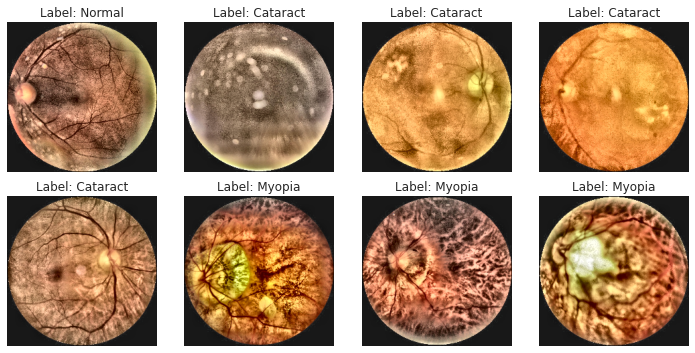

In [27]:
# Displaying randomly selected nine images from the dataset

plt.figure(figsize = (10, 5))
for iter in range(8):
    im = random.choice(range(len(dataset)))
    image = dataset[im][0]
    category = dataset[im][1]
    plt.subplot(2, 4, 1 + iter)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Label: %s" %class_names[category])
plt.tight_layout()

In [28]:
# Splitting the dataset into data and associated labels

x_dev = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)
y_dev = np.array([i[1] for i in dataset])

## Train, Validation, Test - Split

In [29]:
# Shuffling the samples

indexes = np.arange(x_dev.shape[0])
np.random.shuffle(indexes)
X_dev = x_dev[indexes,:]
Y_dev = y_dev[indexes]

# Then, we split our data into train/val/test sets
train_split = np.int(0.6 * Y_dev.size)       # 60% of the data for training
val_split = np.int(0.9 * Y_dev.size)        # 20% each for validation, and testing   

X_train = X_dev[: train_split, : ]
Y_train = Y_dev[: train_split]

X_val = X_dev[train_split : val_split, : ]
Y_val = Y_dev[train_split : val_split]

X_test = X_dev[val_split: , :]
Y_test = Y_dev[val_split : ]

In [30]:
print(f'X_train: {X_train.shape} \tX_val: {X_val.shape} \tX_test: {X_test.shape}')

X_train: (1347, 224, 224, 3) 	X_val: (673, 224, 224, 3) 	X_test: (225, 224, 224, 3)


## Data Scaling

In [31]:
# Min-Max Normalization
Train_min = X_train.min()
Train_max = X_train.max()

X_train = (X_train - Train_min)/(Train_max - Train_min)
X_val = (X_val - Train_min)/(Train_max - Train_min)
X_test = (X_test - Train_min)/(Train_max - Train_min)

## One Hot Encoding

In [32]:
# Representing the labels as one-hot encoded

Y_train_oh = to_categorical(Y_train)
Y_val_oh = to_categorical(Y_val)
Y_test_oh = to_categorical(Y_test)

print(f'Labels: {Y_train[:2]}')
print(f'One hot encoded labels: \n{Y_train_oh[:2]}' )

Labels: [0 3]
One hot encoded labels: 
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]]


## Data Augmentation

In [33]:
# Data Augmentation is used to feed the model with minor changes. This technique is very useful when we have a dataset is very imbalannced and/or small in size.
# Here, we are using techniques such as rotating the images by 15 degrees in a random fashion, flipping the images horizontally. 
# At a time, a batch of 32 images are fed. 

batch_size = 32
gen_params = {"rotation_range":15, "horizontal_flip":True, "fill_mode":'constant', 'cval':0 }
train_gen = ImageDataGenerator(**gen_params)
val_gen = ImageDataGenerator(**gen_params)

train_gen.fit(X_train, seed = 1)
val_gen.fit(X_val, seed = 1)

train_flow = train_gen.flow(X_train, Y_train_oh, batch_size = batch_size)
val_flow = val_gen.flow(X_val, Y_val_oh, batch_size = batch_size) 

Minimum pixel value: 0.0 	 Maximum pixel value: 1.0


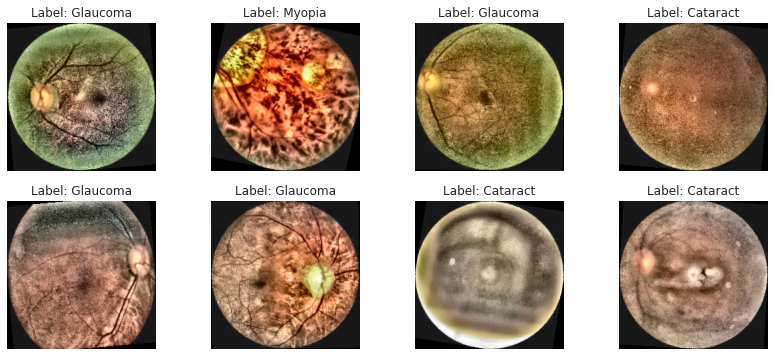

In [34]:
# The keras ImageDataGenerator returns a generator and thus we have to use getitem().

plt.figure(figsize = (14, 6))
X_batch, Y_batch = train_flow.__getitem__(0)
print(f'Minimum pixel value: {X_batch.min()} \t Maximum pixel value: {X_batch.max()}')
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_batch[i])
    plt.title("Label: %s" %class_names[int(Y_batch[i].argmax())])
    plt.axis('off')
plt.show()

## Defining the models

In [35]:
# Here we define our experimental model. This model was finalized after doing a lot of manipulations. Starting with the learning rate to the number of neurons, kernel size,
# number of kernels everything was changed. We used Average Pooling, Max Pooling, batch normalization- no batch normalization, with and without dropouts and find out this model
# was performing better if not the best.

def our_cnn(lr = lr_cnn):
  print(f'\nYou chose our cnn model. \n')

  inputs = Input(shape = i_shape)
  c1 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(inputs)       # Padding is used to keep the dimensions same before and after convolution
  c2 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(c1)
  mp1 = MaxPool2D(2, 2)(c2)
  bn1 = BatchNormalization()(mp1)
  dp1 = Dropout(0.3)(bn1)

  c3 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(dp1)
  c4 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(c3)
  mp2 = MaxPool2D(2, 2)(c4)
  bn2 = BatchNormalization()(mp2)
  dp2 = Dropout(0.25)(bn2)

  c5 = Conv2D(1024, (3, 3), activation = 'relu', padding = 'same')(dp2)
  c6 = Conv2D(1024, (3, 3), activation = 'relu', padding = 'same')(c5)
  mp3 = MaxPool2D(2, 2)(c6)
  bn3 = BatchNormalization()(mp3)
  dp3 = Dropout(0.25)(bn3)

  c7 = Conv2D(1024, (3, 3), activation = 'relu', padding = 'same')(dp3)
  c8 = Conv2D(1024, (3, 3), activation = 'relu', padding = 'same')(c7)
  mp4 = MaxPool2D(2, 2)(c8)
  bn4 = BatchNormalization()(mp4)
  dp4 = Dropout(0.25)(bn4)

  c9 = Conv2D(2048, (3, 3), activation = 'relu', padding = 'same')(dp4)
  c10 = Conv2D(2048, (3, 3), activation = 'relu', padding = 'same')(c9)
  mp5 = MaxPool2D(2, 2)(c10)
  bn5 = BatchNormalization()(mp5)
  dp5 = Dropout(0.3)(bn5)

  flat = Flatten()(dp5)                                                         # Since Dense layers or fully connected layers require input in a single dimension, flatten was used.
  d1 = Dense(1024, activation = 'relu')(flat)
  d2 = Dense(512, activation = 'relu')(d1)
  d3 = Dense(128, activation = 'relu')(d2)
  
  out = Dense(4, activation = 'softmax')(d3)                                    # Softmax outputs each class as an equivalent of probability. 4 classes each corresponding to a single disease

  our_model = Model(inputs = inputs, outputs = out)                             # Finalizing the model
  our_model.compile(optimizer = SGD(learning_rate = lr), loss = 'categorical_crossentropy', metrics = ['accuracy', Precision(), Recall(), AUC_value])
  # Model is compiled with loss as categorical crossentropy, optimizer being stochastic gradient descent with initial learing rate = 1e-5, and four metrics to monitor the training.
    
  return our_model

In [36]:
def vgg_model(train_l = False, lr = lr_cnn):
    print(f'\nYou chose VGG19. \n')
        
    vgg = VGG19(weights = "imagenet", include_top = False, input_shape = (image_size, image_size, 3))     # Importing the model with the weights achieved on Imagenet dataset
    # Classification network/fully connected layers are not imported.
    vgg.trainable = train_l           # Making the trainable paramters freeze

    input_image = Input(shape = i_shape)
    x1 = vgg(input_image, training = False)
    x2 = Flatten()(x1)
    x3 = Dense(256, activation = 'relu')
    out = Dense(4, activation = 'softmax')(x2)
        
    vgg_model = Model(inputs = input_image, outputs = out)
    vgg_model.compile(optimizer = Adam(learning_rate = lr), loss = 'categorical_crossentropy', metrics = ['accuracy', Precision(), Recall(), AUC_value])   

    return vgg_model

In [37]:
def inceptionV3(train_l = False, lr = lr_cnn):
  print(f'\nYou chose InceptionV3. \n')
  # Importing/Calling inception from keras applications

  inception = InceptionV3(weights = 'imagenet', include_top = False, input_shape = i_shape)
  inception.trainable = train_l

  input_image = Input(shape = i_shape)
  x1 = inception(input_image, training = False)
  x2 = Flatten()(x1)
  x3 = Dense(256, activation = 'relu')(x2)
  out = Dense(4, activation = 'softmax')(x3)

  inception_model = Model(inputs = input_image, outputs = out)
  inception_model.compile(optimizer = Adam(learning_rate = lr), loss = 'categorical_crossentropy', metrics = ['accuracy', Precision(), Recall(), AUC_value])
  
  return inception_model

In [38]:
def xception(train_l = False, lr = lr_cnn):
  print(f'\nYou chose Xception. \n')
  # Here, we use the improved version of Inception model on our dataset.
  
  xception = Xception(weights = 'imagenet', include_top = False, input_shape = i_shape)
  xception.trainable = train_l

  input_image = Input(shape = i_shape)
  x1 = xception(input_image, training = False)
  x2 = Flatten()(x1)
  x3 = Dense(256, activation = 'relu')(x2)
  out = Dense(4, activation = 'softmax')(x3)

  xception_model = Model(inputs = input_image, outputs = out)
  xception_model.compile(optimizer = Adam(learning_rate = lr), loss = 'categorical_crossentropy', metrics = ['accuracy', Precision(), Recall(), AUC_value])
  
  return xception_model

## Calling the model

In [39]:
# This function lets you select one model out of all the models.
# An input will be asked from the user.

def model_s():
  model_selection = int(input(f'Choose a model please- \n1: Our CNN model \n2: VGG19 model \n3: InceptionV3 model \n4: Xception Model \n'))

  if model_selection == 1:
    model_name = 'our_cnn.h5'      # Path to save and load the model at.
    model = our_cnn()
    
    model.summary()
    return model, model_name, model_selection

  elif model_selection == 2:
    model_name = 'vgg19.h5'      # Path to save and load the vgg19 model at.
    model = vgg_model()
    
    model.summary()
    return model, model_name, model_selection

  elif model_selection == 3:
    model_name = 'inceptionV3.h5'  # Path to save and load the inceptionV3 model at.
    model = inceptionV3()
    
    model.summary()
    return model, model_name, model_selection

  elif model_selection == 4:
    model_name = 'xception.h5'      # Path to save and load the xception model at.
    model = xception()
    
    model.summary()                                                             # This function also prints the summary of the model, displaying the structure, paramteres.
    return model, model_name, model_selection

  else:
    print('Wrong Choice, please choose again')                                  # In case a wrong input is given, you are again asked to select a proper input.
    model_s()

model, model_name, model_selection = model_s()

Choose a model please- 
1: Our CNN model 
2: VGG19 model 
3: InceptionV3 model 
4: Xception Model 
4

You chose Xception. 

83689472/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               25690368  
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 46,552,876
Trainable params: 25,691,396
Non-trainable pa

## Defining the callbacks

In [40]:
# These callbacks monitor the training. From chaning the learing rate throughout the training process to stopping the training if the validation loss starts increasing everything
# is being controlled by these callbacks.
# Here, we save the best model at the path specified by the variable 'model_name'. This saved model can be later directly used without training for the classifying 4 classes.

model_checkpoint = ModelCheckpoint(model_name, monitor = 'val_loss', save_best_only = True, save_weights_only = False, mode = 'min')

early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', restore_best_weights = True, patience = 5, min_delta = 0.0001)

def scheduler(epoch, lr):
    if (epoch + 1) % 5 == 0 and epoch < 20:
        lr /= 2
    elif (epoch + 1) % 15 == 0:
        lr /= 2
    return lr

lr_schedule = LearningRateScheduler(scheduler, verbose = 1)

## Training the model

In [ ]:
# This cell starts the training of the model and saves the statistics during the training to the variable 'history'.

history = model.fit(train_flow, batch_size = 32, epochs = 50, validation_data = (val_flow), verbose = 1, callbacks = [lr_schedule, model_checkpoint, early_stop])

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
43/43 [==============================] - 54s 489ms/step - loss: 1.0903 - accuracy: 0.5317 - precision: 0.6467 - recall: 0.3773 - auc_value: 0.7726 - val_loss: 0.6158 - val_accuracy: 0.7533 - val_precision: 0.8010 - val_recall: 0.7058 - val_auc_value: 0.9349
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
43/43 [==============================] - 20s 456ms/step - loss: 0.5572 - accuracy: 0.7790 - precision: 0.8239 - recall: 0.7402 - auc_value: 0.9471 - val_loss: 0.5595 - val_accuracy: 0.7712 - val_precision: 0.8185 - val_recall: 0.7370 - val_auc_value: 0.9455
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
43/43 [==============================] - 19s 452ms/step - loss: 0.4488 - accuracy: 0.8458 - precision: 0.8761 - recall: 0.8023 - auc_value: 0.9665 - val_loss: 0.5027 - val_accuracy: 0.8113 - val_p

## Fine Tuning the Model

In [ ]:
# This block of code is used to fine tune the model, i.e. we even update the weights of kernels of convolutional layers to let them adapt better to our classifier.

if model_selection == 1:
    model = load_model('our_cnn.h5')
elif model_selection == 2:
    model = load_model('vgg19.h5')
elif model_selection == 3:
    model = load_model('inceptionV3.h5')
else:
    model = load_model('xception.h5')

model.trainable = True
model.compile(optimizer = Adam(learning_rate = lr_ft), loss = 'categorical_crossentropy', metrics = ['accuracy', Precision(), Recall(), AUC_value])

model.summary()

# Same callbacks are used for fine-tuning as well, so as to stop the model from over-fitting.
tune_history = model.fit(train_flow, batch_size = 32, epochs = 20, validation_data = (val_flow), verbose = 1, callbacks = [lr_schedule, model_checkpoint, early_stop])

## Testing the best saved model

In [ ]:
# Evaluating the model
      
# We use the weights from the best saved model.
model.load_weights(model_name)
Y_pred = model.predict(X_test)
Y_pred = Y_pred.argmax(axis = 1)      # The maximum value of all the values is chosen for each prediction.

loss, accuracy, auc, precision, recall = model.evaluate(X_test, Y_test_oh, verbose = 0)
print(f'loss: {loss} \tAccuracy: {accuracy} \tAUC_value: {auc} \tPrecision: {precision} \tRecall: {recall}')

In [ ]:
# Here, F1 score is calculated on the predicted values.

F1_score = f1_score(y_true = Y_test, y_pred = Y_pred, average = 'weighted')

print(f'F1 score: {F1_score}')

In [ ]:
# This function to calculate confusion matrix was taken from StackOverFlow

classes=['N', 'C', 'G', 'M']                                                    # Labels for the confusion matrix
true_classes = Y_test
print('Confusion Matrix')
cm = confusion_matrix(true_classes, Y_pred)                                     # From sklearn metrics

def plot_confusion_matrix(cm, classes, title = 'Confusion matrix', cmap = plt.cm.Oranges):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 30)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",  color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm, classes)

In [ ]:
# True positive (TP): correct positive prediction
# False positive (FP): incorrect positive prediction
# True negative (TN): correct negative prediction
# False negative (FN): incorrect negative prediction

# Calculating the error rates: TPR, TNR, FPR

def calculate_tpr_tnr_fpr(y_test, y_pred_test):
    actual_pos = y_test == 1
    actual_neg = y_test == 0
    
    true_pos = (y_pred_test == 1) & (actual_pos)
    false_pos = (y_pred_test == 1) & (actual_neg)
    true_neg = (y_pred_test == 0) & (actual_neg)
    false_neg = (y_pred_test == 0) & (actual_pos)
    
    tpr = np.sum(true_pos) / np.sum(actual_pos)
    tnr = np.sum(true_neg) / np.sum(actual_neg)
    fpr = np.sum(false_pos) / np.sum(actual_neg)
    
    return tpr, tnr, fpr

tpr, tnr, fpr = calculate_tpr_tnr_fpr(Y_test, Y_pred)
print(f'True postive rate, Sensitivity: {tpr}')
print(f'True negative rate, Specitivity: {tnr}')
print(f'False positive rate: {fpr}')

In [ ]:
# Plotting the graphs for accuracy, loss, auc_value, precision, recall v/s epochs

plt.figure(figsize = (20, 15))
epochs = np.arange(len(history.history["accuracy"]))

# accuracy v/s epochs
plt.subplot(3, 2, 1)
plt.plot(epochs, history.history["accuracy"])
plt.plot(epochs, history.history["val_accuracy"])
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Val"])
plt.ylim(0, 1)

# loss v/s epochs
plt.subplot(3, 2, 2)
plt.plot(epochs, history.history["loss"])
plt.plot(epochs, history.history["val_loss"])
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])

# auc_value v/s epochs
plt.subplot(3, 2, 3)
plt.plot(epochs, history.history["auc_value"])
plt.plot(epochs, history.history["val_auc_value"])
plt.title("ROC_AUC_Value")
plt.xlabel("Epochs")
plt.ylabel("AUC_Value")
plt.legend(["Train", "Val"])

# precision v/s epochs
plt.subplot(3, 2, 4)
plt.plot(epochs, history.history["precision"])
plt.plot(epochs, history.history["val_precision"])   
plt.title("Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend(["Train", "Val"])

# recall v/s epochs
plt.subplot(3, 2, 5)
plt.plot(epochs, history.history["recall"])
plt.plot(epochs, history.history["val_recall"])
plt.title("Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend(["Train", "Val"])
plt.show()

In [ ]:
# Plotting 8 random images which were classified wrongly

wrong_indexes = np.where(Y_pred != Y_test)[0]
print(f'Number of test images: {Y_test.size}')
print(f'Number of wrong predictions: {wrong_indexes.size}')

sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int), size = 8, replace = False)
plt.figure(figsize = (10, 5))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(2, 4 , ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title(f"Label: {class_names[Y_test[wrong_indexes[jj]]]} \n Predicted: {class_names[Y_pred[wrong_indexes[jj]]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Plotting 8 random images which were classified rightly

right_indexes = np.where(Y_pred == Y_test)[0]
print(f'Number of test images: {Y_test.size}')
print(f'Number of right predictions: {right_indexes.size}')

sample_indexes = np.random.choice(np.arange(right_indexes.shape[0], dtype = int), size = 8, replace = False)
plt.figure(figsize = (10, 5))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(2, 4 , ii+1)
    plt.imshow(X_test[right_indexes[jj]], cmap = "gray")
    plt.title(f"Label: {class_names[Y_test[right_indexes[jj]]]} \n Predicted: {class_names[Y_pred[right_indexes[jj]]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()